# Red neuronal LSTM para predecir niveles del río Orinoco

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras import Sequential, layers
from keras.optimizers import RMSprop, Adam

In [272]:
# data = pd.read_csv("data/dataset_combinado.csv")
data = pd.read_csv("data/dataset_imputado_simpleml.csv")
data.head()

,fecha,ayacucho,caicara,ciudad_bolivar,palua
0,1974/01/01,43.34,24.98,6.89,3.83
1,1974/01/02,43.25,24.88,6.78,3.93
2,1974/01/03,43.14,24.78,6.73,3.75
3,1974/01/04,43.04,24.68,6.68,3.49
4,1974/01/05,42.94,24.58,6.62,3.64


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18683 entries, 0 to 18682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fecha           18683 non-null  object 
 1   ayacucho        18683 non-null  float64
 2   caicara         18683 non-null  float64
 3   ciudad_bolivar  18683 non-null  float64
 4   palua           18666 non-null  float64
dtypes: float64(4), object(1)
memory usage: 729.9+ KB


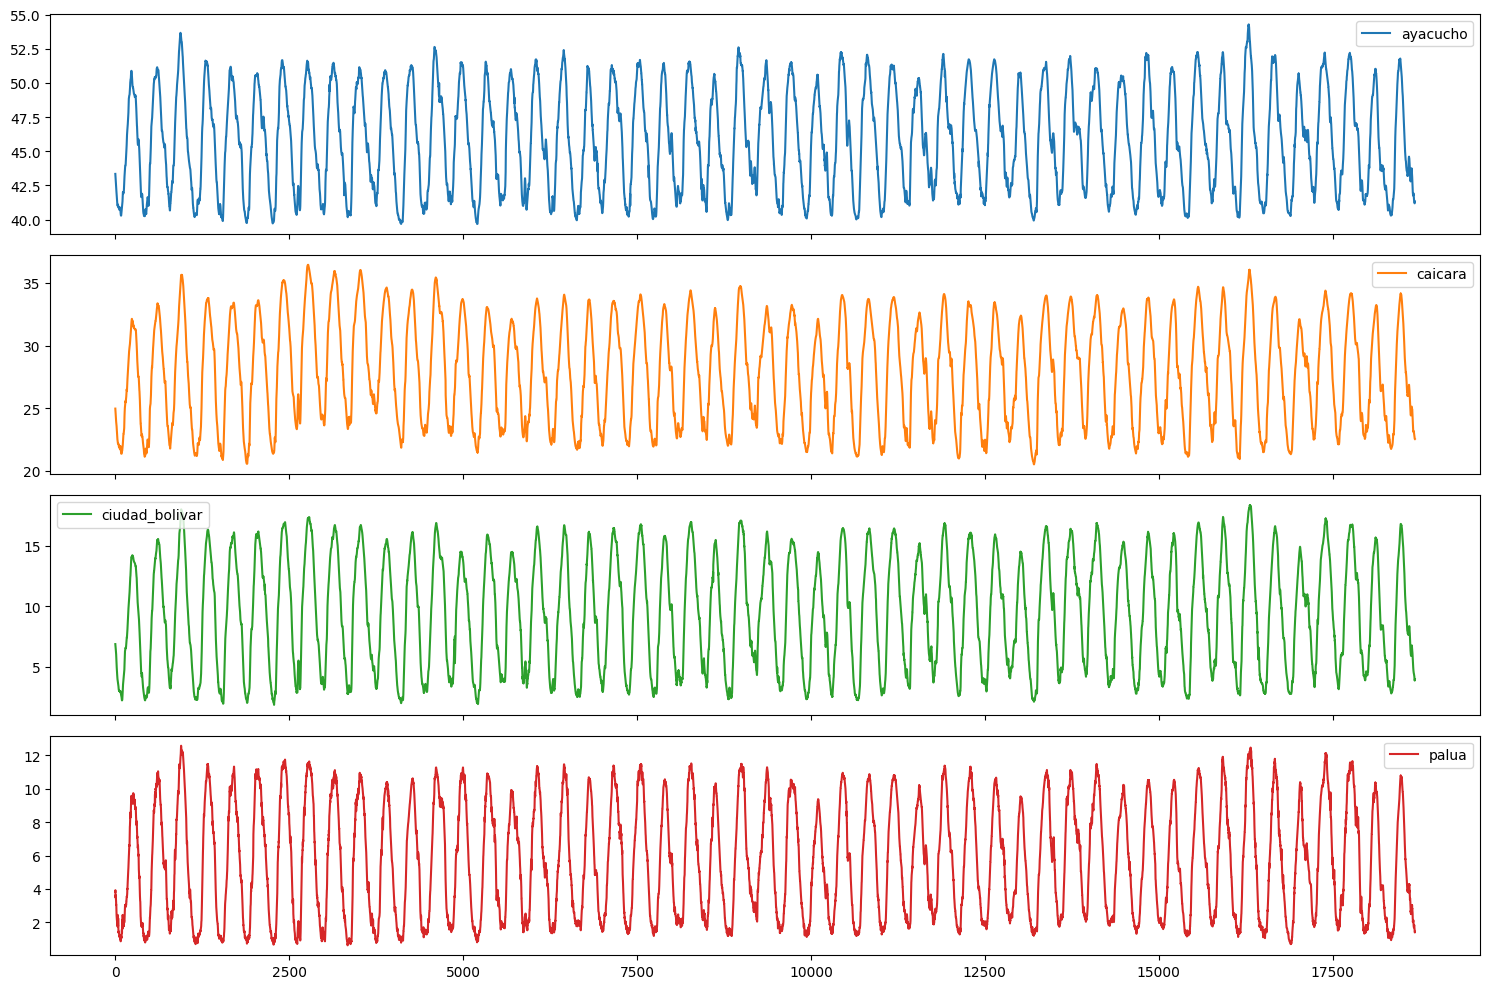

In [274]:
# Graficar valores de cada columna
data[['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']].plot(subplots=True, figsize=(15, 10))
plt.tight_layout()

In [275]:
# Interpolación de valores faltantes
data["palua"] = data["palua"].interpolate(method="linear", limit_direction="both")
# data["fecha"] = pd.to_datetime(data["fecha"])
# mask = data['fecha'].dt.year.isin([2007, 2008])
# data.loc[mask, "palua"] = data.loc[mask, "palua"].interpolate(
#     method="linear", limit_direction="both"
# )

In [276]:
# Graficar valores de cada columna
# data[["ayacucho", "caicara", "ciudad_bolivar", "palua"]].plot(
#     subplots=True, figsize=(15, 10)
# )
# plt.tight_layout()

In [277]:
# Eliminar registros con valores nulos
data.dropna(inplace=True)

In [278]:
# Normalizar las nuevas características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[[
    'ayacucho',
    'caicara',
    'ciudad_bolivar',
    'palua',
]])

In [279]:
# Crear secuencias para predecir múltiples días futuros
sequence_length = 365  # Ventana de entrada
forecast_steps = 10   # Número de días futuros a predecir
batch_size = 256

In [280]:
# Elegir índice de corte para training y testing (por ejemplo 80% para training)
split_index = int(len(data_scaled) * 0.8)

# Asegurarse de que haya suficientes datos para generar secuencias
if split_index < sequence_length + forecast_steps:
    raise ValueError("El conjunto de datos es demasiado pequeño para generar las secuencias requeridas.")

train_data = data_scaled[:split_index]
test_data = data_scaled[split_index:]

In [281]:
def split_sequences(sequences, n_steps_in: int, n_steps_out: int):
    """
    Divide una secuencia multivariada en muestras de entrada y salida

    Usado para problemas donde se reciben múltiples secuencias, y
    se desea predecir el siguiente valor de cada una

    Tomado de
    https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    """
    X, y = list(), list()
    for i in range(len(sequences)):
		# find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [282]:
train_X, train_y = split_sequences(train_data, sequence_length, forecast_steps)
test_X, test_y = split_sequences(test_data, sequence_length, forecast_steps)

# Visualizar
print(train_X[0], train_y[0])

[[-0.67999201 -0.71232562 -0.5648475  -0.56260059]
 [-0.70416377 -0.73634341 -0.58878236 -0.53317924]
 [-0.73370702 -0.7603612  -0.59966185 -0.58613767]
 ...
 [-0.86262305 -0.92848572 -0.80419612 -0.91565683]
 [-0.91096656 -0.95250351 -0.84336226 -0.98332594]
 [-0.95125282 -1.00053909 -0.8781766  -1.00392089]] [[-0.97005308 -1.00053909 -0.91081505 -1.00980516]
 [-1.01033934 -1.02455688 -0.9391017  -1.04216865]
 [-1.03719684 -1.04857467 -0.96956425 -1.0627636 ]
 [-1.0506256  -1.07259246 -0.99785091 -1.08630068]
 [-1.09091186 -1.09661024 -1.01525808 -1.10395349]
 [-1.10702636 -1.14464582 -1.04354473 -1.11572203]
 [-1.12045511 -1.16866361 -1.0674796  -1.14514338]
 [-1.13119812 -1.18067251 -1.08053498 -1.15985406]
 [-1.13656962 -1.1926814  -1.08053498 -1.15102766]
 [-1.13388387 -1.2046903  -1.07835908 -1.13925911]]


In [283]:
n_features = train_X.shape[2] # Número de características

# Ajustar el modelo para predecir forecast_steps valores futuros
model = Sequential(
    [
        layers.LSTM(
            units=100,
            activation="relu",
            input_shape=(sequence_length, n_features),
        ),
        layers.Dropout(0.3),
        layers.RepeatVector(forecast_steps),
        layers.LSTM(units=100, activation="relu", return_sequences=True),
        layers.Dropout(0.3),
        layers.TimeDistributed(layers.Dense(n_features)),
    ]
)

# Compilar el modelo
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mean_absolute_error"],
)

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\orinoco_lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [284]:
# Entrenar el modelo con más épocas
history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=5,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 713ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 725ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/5
51/57 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: 

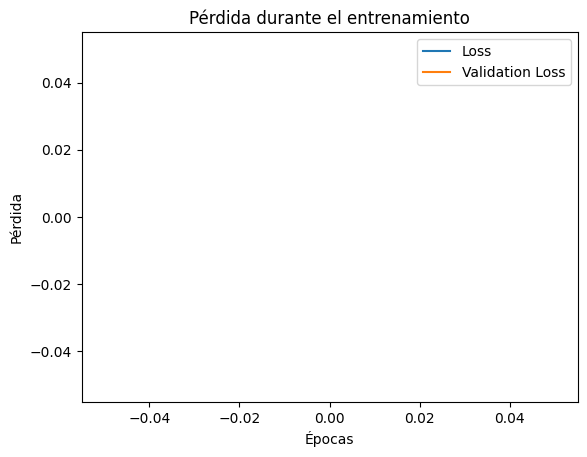

In [ ]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Predicciones (10 días x 4 ciudades):
[[nan nan nan nan]]
Valores reales (si están disponibles):
[[40.9  22.5   3.68  1.39]]


<Figure size 1000x600 with 0 Axes>

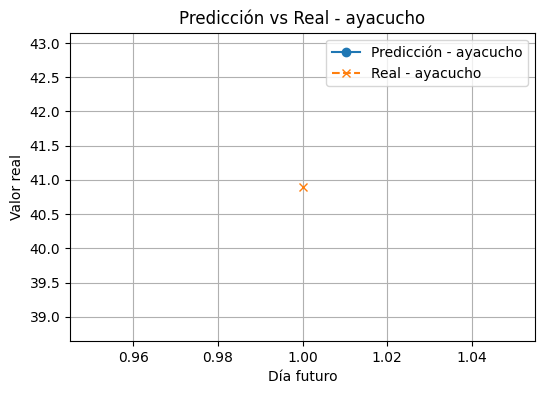

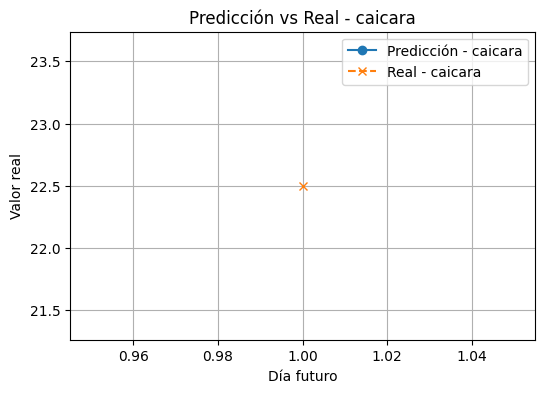

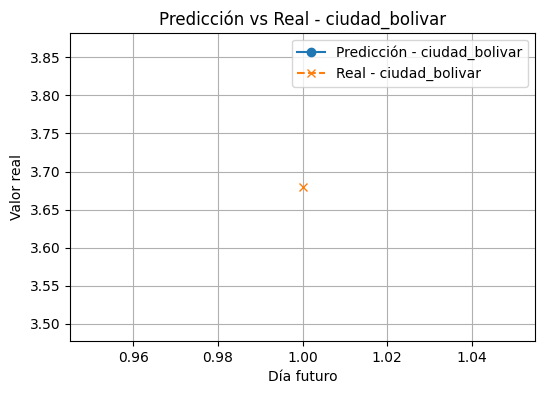

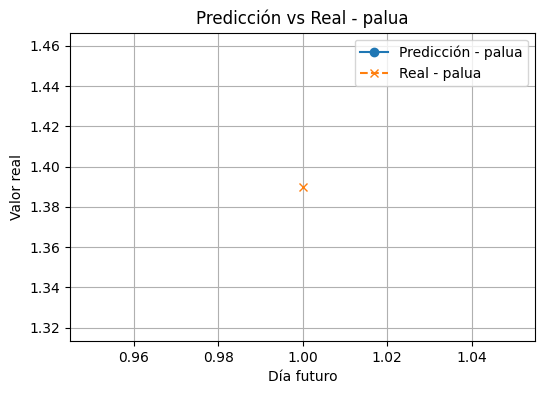

In [ ]:
# Tomar la última secuencia del set de test para predecir los próximos 10 días
last_sequence = test_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, test_data.shape[1]))

# Predecir los próximos 10 días para las 4 ciudades
future_pred = model.predict(last_sequence)  # shape: (1, 10, 4)
future_pred = future_pred[0]  # shape: (10, 4)

# Desnormalizar la salida para obtener los valores reales
future_pred_real = scaler.inverse_transform(future_pred)

# Obtener los valores reales correspondientes (si están disponibles)
try:
    real_future = scaler.inverse_transform(test_data[-sequence_length: -sequence_length + forecast_steps, :4])
except Exception:
    real_future = None

print("Predicciones (10 días x 4 ciudades):")
print(future_pred_real)
print("Valores reales (si están disponibles):")
print(real_future)

# Graficar
ciudades = ['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']
dias = np.arange(1, forecast_steps + 1)

plt.figure(figsize=(10, 6))
for i, ciudad in enumerate(ciudades):
    plt.figure(figsize=(6, 4))
    plt.plot(dias, future_pred_real[:, i], marker='o', label=f'Predicción - {ciudad}')
    if real_future is not None and real_future.shape == (forecast_steps, 4):
        plt.plot(dias, real_future[:, i], marker='x', linestyle='--', label=f'Real - {ciudad}')
    plt.xlabel('Día futuro')
    plt.ylabel('Valor real')
    plt.title(f'Predicción vs Real - {ciudad}')
    plt.legend()
    plt.grid()
    plt.show()